In [1]:
import os
import zipfile # Allows us to zip and unzip files
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
import glob
import shutil
from collections import defaultdict
import cv2
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folders = sorted(glob.glob('/content/drive/MyDrive/proy_deeplearningADS/images/*'))
len(train_folders)

In [2]:
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
class_indices = [0, 1, 2, 3] # asignando un indice a cada clase

## Creación de directorios

In [ ]:
!rm -rf data

DATA_DIR = Path('/content/drive/MyDrive/proy_deeplearningADS/data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True) # creando sub carpetas para el proyecto

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob.glob(f'{train_folders[cls_index]}/*'))
  print(image_paths)
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
     shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/') # Colocando las imagenes en sus respectivas carpetas 

['/content/drive/MyDrive/images/cataract/2173_right.jpg'
 '/content/drive/MyDrive/images/cataract/2097_right.jpg'
 '/content/drive/MyDrive/images/cataract/2234_right.jpg' ...
 '/content/drive/MyDrive/images/cataract/_149_9419457.jpg'
 '/content/drive/MyDrive/images/cataract/970_left.jpg'
 '/content/drive/MyDrive/images/cataract/2133_right.jpg']
cataract: 1038
['/content/drive/MyDrive/images/diabetic_retinopathy/10017_right.jpeg'
 '/content/drive/MyDrive/images/diabetic_retinopathy/10015_left.jpeg'
 '/content/drive/MyDrive/images/diabetic_retinopathy/10149_right.jpeg' ...
 '/content/drive/MyDrive/images/diabetic_retinopathy/10085_right.jpeg'
 '/content/drive/MyDrive/images/diabetic_retinopathy/10059_left.jpeg'
 '/content/drive/MyDrive/images/diabetic_retinopathy/10212_right.jpeg']
diabetic_retinopathy: 1098
['/content/drive/MyDrive/images/glaucoma/583_left.jpg'
 '/content/drive/MyDrive/images/glaucoma/1279_left.jpg'
 '/content/drive/MyDrive/images/glaucoma/1488_right.jpg' ...
 '/content

In [5]:
train_dir = '/content/drive/MyDrive/proy_deeplearningADS/data/train'
validation_dir = '/content/drive/MyDrive/proy_deeplearningADS/data/val'
test_dir = '/content/drive/MyDrive/proy_deeplearningADS/data/test'

## Muestra de clases

In [ ]:
def plot_one_sample_of_each(base_path):
    cols = 4
    rows = int(np.ceil(len(class_names) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(class_names)):
        cls = class_names[i]
        img_path =  base_path + '/' + cls + '/**'
        path_contents = glob.glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

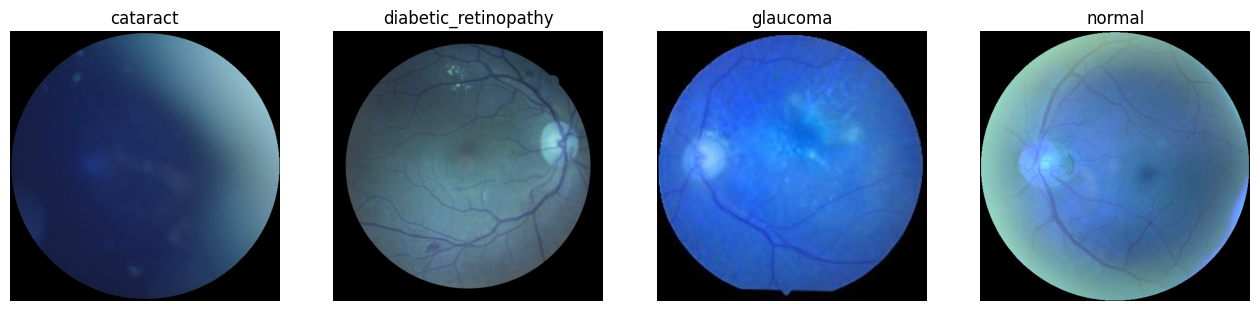

In [ ]:
plot_one_sample_of_each(train_dir)

## Data Augmentation

In [28]:
def scalar(img):
    return img

from keras.applications.inception_v3 import preprocess_input

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(#rescale = 1./255,
                                   preprocessing_function= preprocess_input,
                                   #rotation_range = 40,                                 
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   #horizontal_flip = True,
                                   vertical_flip=True
                                   )


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input )
                                  #rescale = 1./255 )

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, #previously defined
        target_size=(224, 224),  # All images will be resized to 224 x 224
        batch_size=32,
        # Specify the classes explicitly
        classes = class_names,
        color_mode= 'rgb',
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')   

# Flow validation images in batches of 32 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,  #previously defined
                                                          batch_size  = 32,
                                                          classes = class_names,
                                                          color_mode= 'rgb',
                                                          class_mode='categorical', 
                                                          target_size=(224, 224))

test_generator =  test_datagen.flow_from_directory( test_dir,  #previously defined
                                                          batch_size  = 32,
                                                          classes = class_names,
                                                          color_mode= 'rgb',
                                                          class_mode='categorical', 
                                                          target_size=(224, 224))

Found 3372 images belonging to 4 classes.
Found 422 images belonging to 4 classes.
Found 423 images belonging to 4 classes.


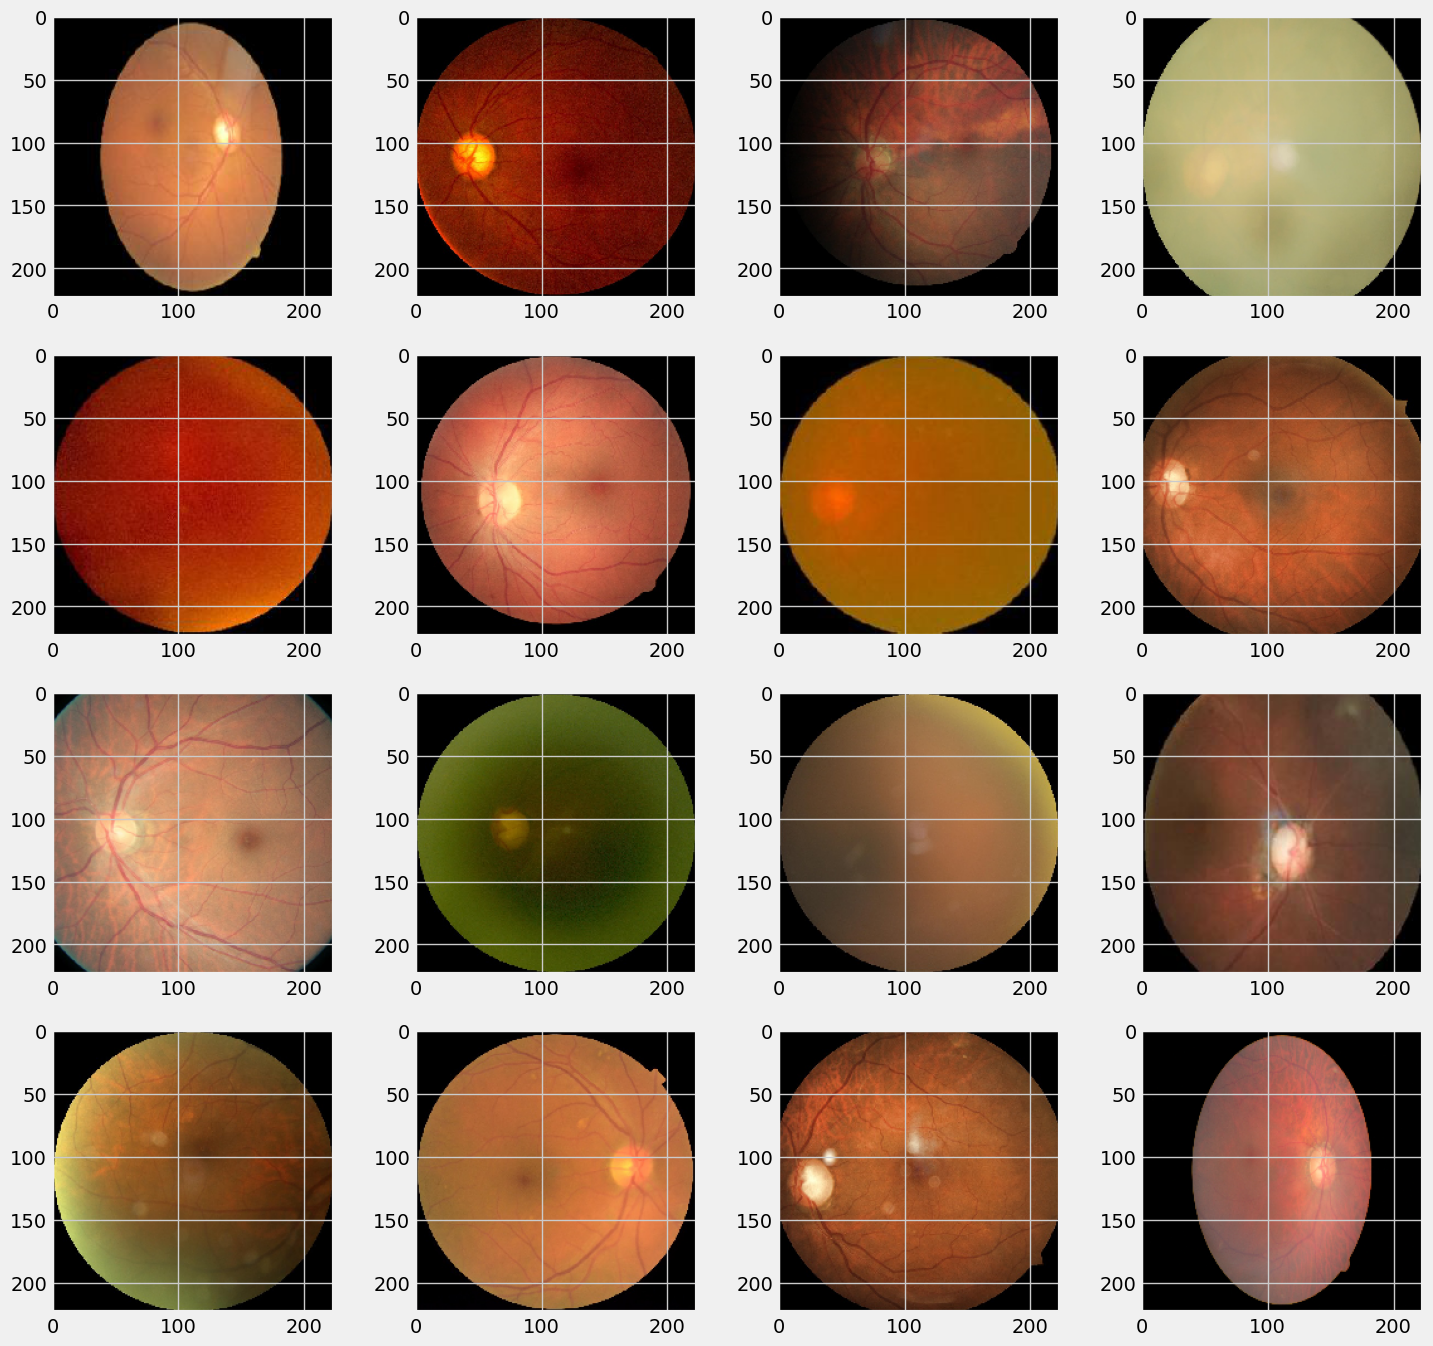

In [ ]:
# Get a batch of augmented images from train_generator
augmented_images, _ = train_generator.next()

# Plot some augmented images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])

plt.show()

## Construcción de modelos

In [7]:
!wget -q \
    https://www.dropbox.com/s/1dgux9udiby9zev/Inception_V3.zip

In [8]:
!unzip 'Inception_V3'

Archive:  Inception_V3.zip
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [9]:
# Import the inception model  
#from tensorflow.keras.applications.efficientnet import EfficientNetB3
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top= False, weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                                            input_shape= (224, 224,3))

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [11]:
for layer in base_model.layers:
  layer.trainable = False

In [33]:
x = base_model.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
x= layers.BatchNormalization()(x)
# Add a fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), # probar mas capas
                bias_regularizer= regularizers.l1(0.006), activation='relu')(x)  
x = layers.Dropout(0.45, seed= 123)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)           
model = Model(base_model.input, x) 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [35]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [36]:
checkpoint_filepath = '/content/drive/MyDrive/proy_deeplearningADS/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Entrenamiento

In [37]:
#callbacks = myCallback()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size 
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size 

history=model.fit(  train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[model_checkpoint_callback],
                    epochs=50 
)

Epoch 1/50
105/105 [==============================] - 48s 408ms/step - loss: 5.7230 - acc: 0.7099 - val_loss: 5.1391 - val_acc: 0.7572
Epoch 2/50
105/105 [==============================] - 42s 402ms/step - loss: 5.0002 - acc: 0.8257 - val_loss: 4.9565 - val_acc: 0.7981
Epoch 3/50
105/105 [==============================] - 42s 400ms/step - loss: 4.5707 - acc: 0.8722 - val_loss: 4.3924 - val_acc: 0.8582
Epoch 4/50
105/105 [==============================] - 42s 399ms/step - loss: 4.1789 - acc: 0.8988 - val_loss: 4.1214 - val_acc: 0.8486
Epoch 5/50
105/105 [==============================] - 42s 402ms/step - loss: 3.8397 - acc: 0.9111 - val_loss: 3.8499 - val_acc: 0.8726
Epoch 6/50
105/105 [==============================] - 42s 400ms/step - loss: 3.5202 - acc: 0.9251 - val_loss: 3.6354 - val_acc: 0.8630
Epoch 7/50
105/105 [==============================] - 41s 392ms/step - loss: 3.1909 - acc: 0.9404 - val_loss: 3.2309 - val_acc: 0.8582
Epoch 8/50
105/105 [==============================] - 4

In [38]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['acc']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

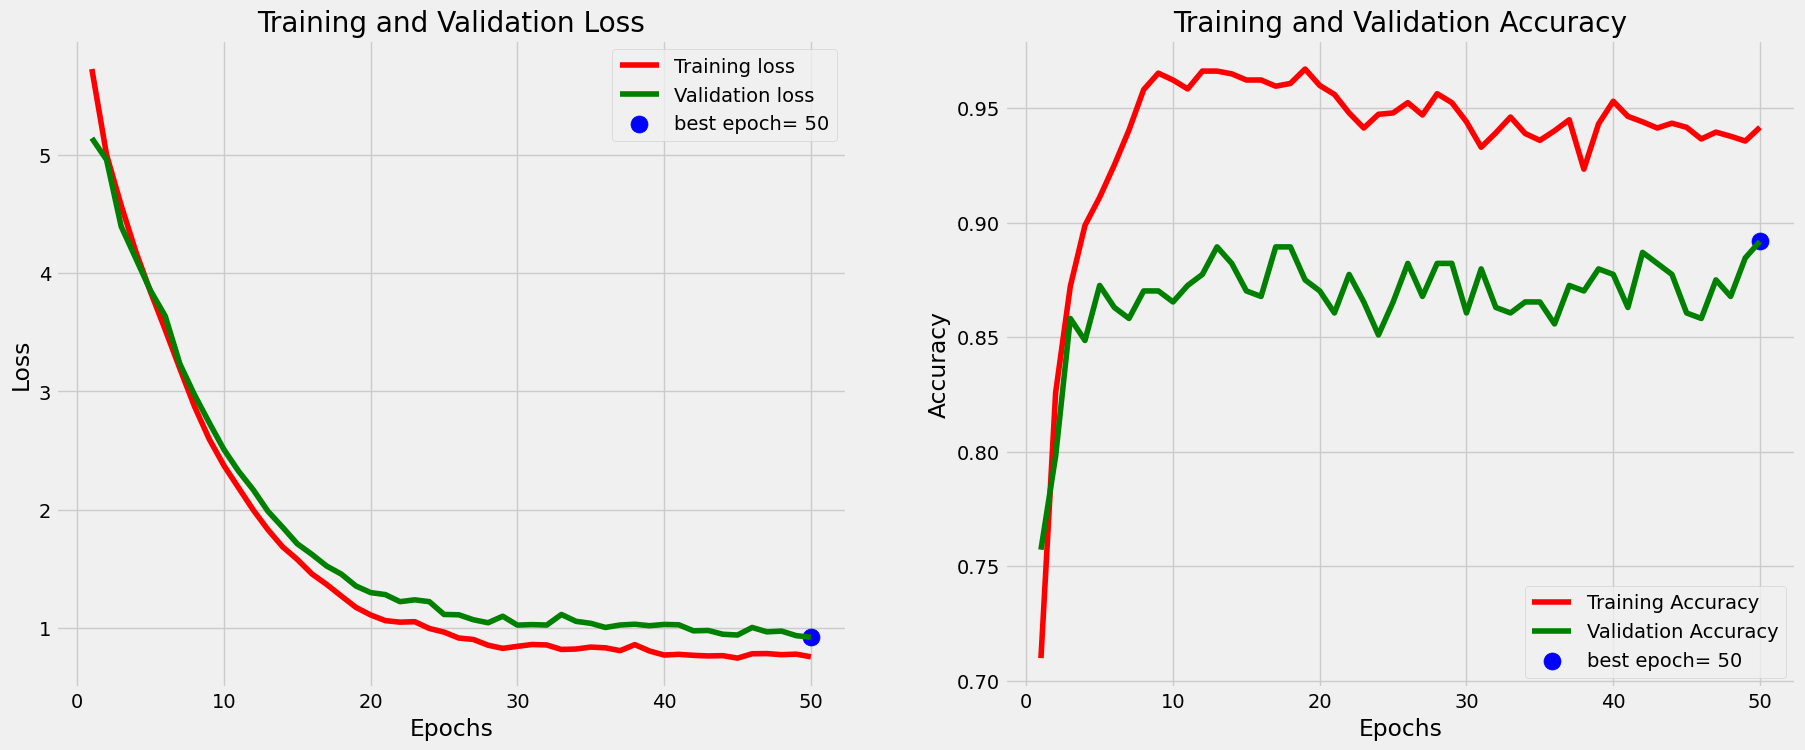

In [39]:
plot_training(history)

In [40]:
from keras.models import load_model
model_best= load_model('/content/drive/MyDrive/proy_deeplearningADS/best_model.h5')

In [19]:
model_best

## Testeo

In [41]:
ts_length = len(test_dir)
test_batch_size = test_generator.batch_size
test_steps = ts_length // test_batch_size

train_score = model_best.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model_best.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = model_best.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 500ms/step - loss: 0.8056 - acc: 0.9375
Train Loss:  0.6017195582389832
Train Accuracy:  1.0
--------------------
Validation Loss:  0.8057026863098145
Validation Accuracy:  0.90625
--------------------
Test Loss:  0.8055633902549744
Test Accuracy:  0.9375


## Matriz de Confusión y Reporte de Clasificación

In [42]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

### Armando data de testeo

In [96]:
# Especificando el directorio que contiene las imágenes
test_folders = sorted(glob.glob('/content/drive/MyDrive/proy_deeplearningADS/data/test/*'))

images = []

In [98]:
image_paths = np.array(glob.glob(f'{test_folders[0]}/*'))
image_paths1 = np.array(glob.glob(f'{test_folders[1]}/*'))
image_paths2 = np.array(glob.glob(f'{test_folders[2]}/*'))
image_paths3 = np.array(glob.glob(f'{test_folders[3]}/*'))

image_paths= np.append(image_paths, image_paths1)
image_paths = np.append(image_paths, image_paths2)
image_paths= np.append(image_paths, image_paths3)

In [99]:
len(image_paths) # 423 imagenes para testeo

423

In [100]:
#preprocesando imágenes :
for path in image_paths:
  img = image.load_img(path, target_size=(224, 224))# Cargando la imagen en el tamaño requerido para el modelo
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  images.append(x)

In [101]:
images = np.vstack(images)

In [102]:
preds = model_best.predict(images)
y_pred = np.argmax(preds, axis=1)

14/14 [==============================] - 1s 69ms/step


In [103]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 1, 1,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Confusion Matrix, Without Normalization
[[ 95   0   5   4]
 [  0 108   0   2]
 [  5   2  79  15]
 [  0   3  10  95]]
                      precision    recall  f1-score   support

            cataract       0.95      0.91      0.93       104
diabetic_retinopathy       0.96      0.98      0.97       110
            glaucoma       0.84      0.78      0.81       101
              normal       0.82      0.88      0.85       108

            accuracy                           0.89       423
           macro avg       0.89      0.89      0.89       423
        weighted avg       0.89      0.89      0.89       423



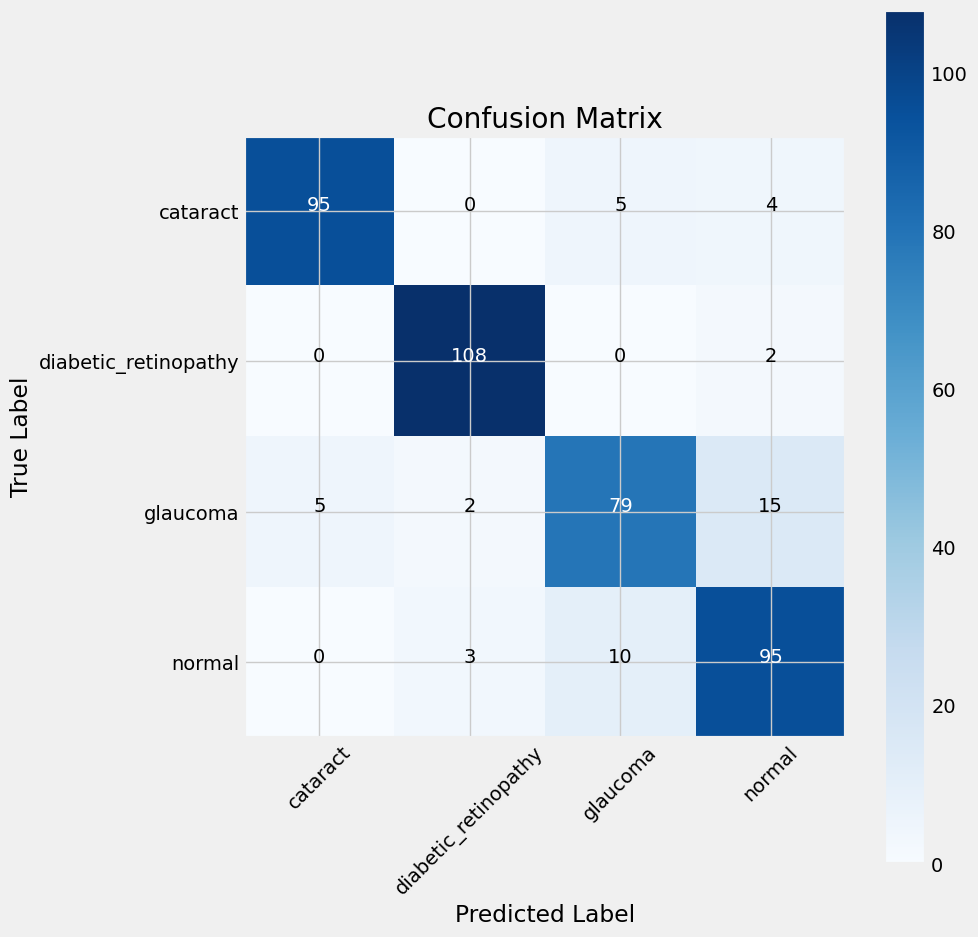

In [104]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))